In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
# Datetime parser

def parser(x):
	return datetime.strptime(x, '%Y-%m-%d')

In [4]:
# Load dataset

dataset = pd.read_csv('/content/drive/My Drive/Datasets/daily-min-temperatures.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

dataset.head()

Date
1981-01-01    20.7
1981-01-02    17.9
1981-01-03    18.8
1981-01-04    14.6
1981-01-05    15.8
Name: Temp, dtype: float64

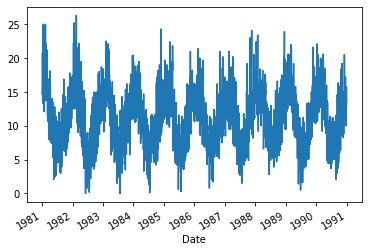

In [5]:
# Plot dataset

dataset.plot()
plt.show()

In [6]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import mean_squared_error
from math import sqrt

Processing Time-Series Data

In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
	df = pd.DataFrame(data)
	columns = [df.shift(i) for i in range(1, lag+1)]
	columns.append(df)
	df = pd.concat(columns, axis=1)
	return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

# #invert differenced value
# def inverse_difference(history, yhat, interval=1):
#   return yhat + history[-interval]

In [8]:
# # scale train dan test data to [-1, 1]
# def scale(train, test):
#   # fit scaler
#   scaler = MinMaxScaler(feature_range=(-1,1))
#   scaler = scaler.fit(train)
#   #transform train
#   train = train.reshape(train.shape[0], train.shape[1])
#   train_scaled = scaler.transform(train)
#   #transform test
#   test = test.reshape(test.shape[0], test.shape[1])
#   test_scaled = scaler.transform(test)
#   return scaler, train_scaled, test_scaled

# # inverse scaling for a forecasted value
# def invert_scale(scaler, X, yhat):
#   new_row = [x for x in X] + [yhat]
#   array = np.array(new_row)
#   array = array.reshape(1, len(array))
#   inverted = scaler.inverse_transform(array)
#   return inverted[0, -1]

In [9]:
lag = 1

# transform data to be stationary
raw_values = dataset.values
raw_values
diff_values = difference(raw_values, 1)
diff_values

# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, lag)
supervised
supervised_values = supervised.values[lag:, :]
supervised_values

array([[-2.8,  0.9],
       [ 0.9, -4.2],
       [-4.2,  1.2],
       ...,
       [-0.4, -0.1],
       [-0.1,  2.2],
       [ 2.2, -2.7]])

In [10]:
split_percentage = 0.75

train_size = int(split_percentage * len(supervised_values))

train, test = supervised_values[0:train_size], supervised_values[train_size:len(supervised_values)]

In [11]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(train)

train_scaled = scaler.transform(train)
test_scaled = scaler.transform(test)

In [12]:
train_scaled

array([[-0.11607143,  0.21428571],
       [ 0.21428571, -0.24107143],
       [-0.24107143,  0.24107143],
       ...,
       [-0.16071429,  0.375     ],
       [ 0.375     ,  0.125     ],
       [ 0.125     , -0.16071429]])

## Baseline Model

In [13]:
neurons = 1
epoch = 1000
batch_size = 32

feature_train, label_train = train_scaled[:, 0:-1], train_scaled[:, -1]
feature_test, label_test = test_scaled[:, 0:-1], test_scaled[:, -1]

model = Sequential()
model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
history_baseline = model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0681 - val_loss: 0.0585
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0636 - val_loss: 0.0566
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0621 - val_loss: 0.0559
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0614 - val_loss: 0.0556
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0611 - val_loss: 0.0554
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0609 - val_loss: 0.0553
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0607 - val_loss: 0.0552
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0604 - val_loss: 0.0550
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0602 - val_loss: 0.0549
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0600 - val_loss: 0.0548

In [14]:
loss = model.evaluate(feature_test, verbose=2)

print("Test loss:", loss)

29/29 - 0s - loss: 0.0000e+00
Test loss: 0.0


In [15]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Loss (MSE)')
  plt.legend()
  plt.grid(True)

In [16]:
history_baseline_dataframe = pd.DataFrame(history_baseline.history)
history_baseline_dataframe['epoch'] = history_baseline.epoch
history_baseline_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
742,0.058747,0.053976,742
236,0.058747,0.053976,236
497,0.058750,0.053976,497
854,0.058794,0.053976,854
711,0.058831,0.053976,711
...,...,...,...
4,0.061116,0.055420,4
3,0.061417,0.055568,3
2,0.062088,0.055896,2
1,0.063550,0.056556,1


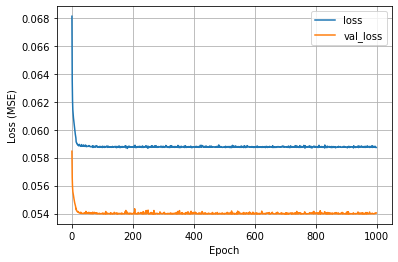

In [17]:
plot_loss(history_baseline)

## Deeper Model

In [18]:
neurons = 1
epoch = 1000
batch_size = 32

deeper_model = Sequential()
deeper_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
deeper_model.add(Dense(5, activation='relu'))
deeper_model.add(Dense(1))
deeper_model.compile(loss='mean_squared_error', optimizer='adam')
deeper_model_history = deeper_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0760 - val_loss: 0.0564
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0596 - val_loss: 0.0548
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0591 - val_loss: 0.0547
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0590 - val_loss: 0.0546
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0546
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0589 - val_loss: 0.0545
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0545
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0545
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0545
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0587 - val_loss: 0.0544

In [19]:
deeper_model_dataframe = pd.DataFrame(deeper_model_history.history)
deeper_model_dataframe['epoch'] = deeper_model_history
deeper_model_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
692,0.058112,0.053839,<tensorflow.python.keras.callbacks.History obj...
999,0.058154,0.053841,<tensorflow.python.keras.callbacks.History obj...
362,0.058180,0.053843,<tensorflow.python.keras.callbacks.History obj...
361,0.058145,0.053846,<tensorflow.python.keras.callbacks.History obj...
749,0.058153,0.053847,<tensorflow.python.keras.callbacks.History obj...
...,...,...,...
3,0.058972,0.054620,<tensorflow.python.keras.callbacks.History obj...
330,0.057975,0.054635,<tensorflow.python.keras.callbacks.History obj...
2,0.059063,0.054712,<tensorflow.python.keras.callbacks.History obj...
1,0.059567,0.054824,<tensorflow.python.keras.callbacks.History obj...


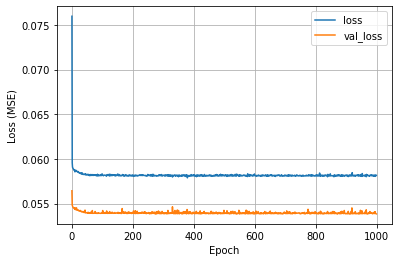

In [20]:
plot_loss(deeper_model_history)

## Wider Model

In [21]:
neurons = 50
epoch = 1000
batch_size =32

wider_model = Sequential()
wider_model.add(Dense(neurons, activation='relu', input_dim=feature_train.shape[1]))
wider_model.add(Dense(1))
wider_model.compile(loss='mean_squared_error', optimizer='adam')
wider_model_history = wider_model.fit(feature_train, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0624 - val_loss: 0.0541
Epoch 2/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0588 - val_loss: 0.0540
Epoch 3/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0542
Epoch 4/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0584 - val_loss: 0.0539
Epoch 6/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0539
Epoch 7/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0581 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0538
Epoch 9/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0542
Epoch 10/1000
86/86 [==============================] - 0s 1ms/step - loss: 0.0582 - val_loss: 0.0539

In [22]:
wider_model_dataframe = pd.DataFrame(wider_model_history.history)
wider_model_dataframe['epoch'] = wider_model_history.epoch
wider_model_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
12,0.058113,0.053716,12
65,0.057850,0.053769,65
60,0.058101,0.053770,60
20,0.057865,0.053774,20
68,0.057906,0.053775,68
...,...,...,...
783,0.057417,0.054584,783
100,0.057781,0.054608,100
883,0.057311,0.054612,883
56,0.057842,0.054689,56


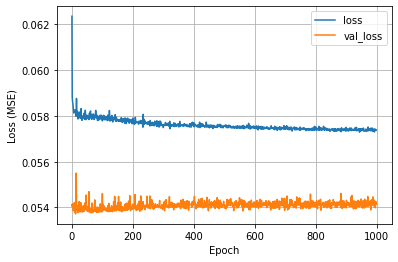

In [23]:
plot_loss(wider_model_history)

## LSTM

In [24]:
from tensorflow.keras.layers import LSTM

epoch = 1000
batch_size = 32

feature_train_reshaped = np.reshape(feature_train, (feature_train.shape[0], 1, feature_train.shape[1]))
feature_test_reshaped = np.reshape(feature_test, (feature_test.shape[0], 1, feature_test.shape[1]))

lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', input_dim=feature_train.shape[1])) # 50 LSTM Block
lstm_model.add(Dense(1))
lstm_model.compile(optimizer='adam', loss='mean_squared_error')

lstm_model_history = lstm_model.fit(feature_train_reshaped, label_train, epochs=epoch, batch_size=batch_size, validation_data=(feature_test_reshaped, label_test))

Epoch 1/1000
86/86 [==============================] - 0s 4ms/step - loss: 0.0645 - val_loss: 0.0545
Epoch 2/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0590 - val_loss: 0.0541
Epoch 3/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 4/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0587 - val_loss: 0.0540
Epoch 5/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0540
Epoch 6/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0586 - val_loss: 0.0539
Epoch 7/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539
Epoch 8/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0542
Epoch 9/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0584 - val_loss: 0.0540
Epoch 10/1000
86/86 [==============================] - 0s 2ms/step - loss: 0.0585 - val_loss: 0.0539

In [25]:
lstm_history_dataframe = pd.DataFrame(lstm_model_history.history)
lstm_history_dataframe['epoch'] = lstm_model_history.epoch
lstm_history_dataframe.sort_values(by='val_loss', ascending=True)

,loss,val_loss,epoch
191,0.057823,0.053762,191
195,0.057864,0.053767,195
213,0.057833,0.053767,213
261,0.057899,0.053768,261
763,0.057749,0.053768,763
...,...,...,...
30,0.058153,0.054170,30
74,0.058104,0.054178,74
7,0.058496,0.054190,7
20,0.058242,0.054217,20


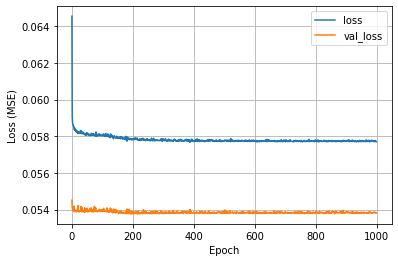

In [26]:
plot_loss(lstm_model_history)

# Kesimpulan

Dari data di atas, didapatkan hasil:

*   Baseline Model 	
loss 0.058747   
val_loss 0.053976    
epoch 742

*   Deeper Model
loss 0.058112		    
val_loss 0.053839		    
epoch 692
     
*   Wider Model    
loss 0.058113	   
val_loss 0.053716     
epoch 12

*   LSTM           
loss 0.057823	   
val_loss 0.053762	    
epoch 191

Nilai validation loss terkecil ada pada Wider Model epoch 12.Perbedaan hasil validation loss dan epoch setiap model cukup besar. Hal ini berarti dari awal model yang diberikan, neurons yang dikasih terlalu kecil. Pada deeper model sendiri validation loss didapatkan pada epoch ke 692, meningkat dari hasil baseline model sehingga memungkinkan ketika dilakukan penambahan kedalaman layer dan diberikan neuron yang lebih lebar akan mendapatkan nilai epoch jauh lebih kecil lagi. Pada model LSTM sendiri hasilnya tidak jauh berbeda dengan wider model pada nilai validation loss, sedangkan untuk nilai loss training lebih baik pada LSTM. Jadi mungkin dengan memakai LSTM mungkin nilai loss dan validation loss yang dihasilkan bisa lebih kecil, namun pada dataset ini memakai wider model sudah cukup untuk menghasilkan validation loss terbaik. 



